## What is the Zestimate and what is the logerror?

Before diving in to this whole 'Zestimate' thing, it may help to clear up a few ideas, at least as we understand them in pursuing our project's goal.

There are two main values dictating home sale prices:

1.) The Market Value = what the BUYER says the property is worth; and

2.) The Appraised Value = what the BANK says the property is worth.

Banks win 99% of the time because banks have 99% of the money, and that's a good thing - it helps mitigate reality between Buyer and Seller.

I can't demand my house sell for a million dollars when the bank says it's only worth a Happy Meal.  Conversely, the buyer can't buy my home for a Happy Meal when the bank says it's **AT LEAST** worth a Taco Bell Tripleupa Box.  (That took some practice.)

Undertanding this communication gap, Zillow was created in 2006 as a way of providing information to both home-buyers and home-sellers, the end goal being a mutual understanding at the beginning of price negotiations.  One of their flagship offerings is their 'Zestimate,' a constantly-updated and fine-tuned home valution model that is used to predict the market value of a home based on things like '*home facts, location, and market conditions*' (italics are directly from their website, https://www.zillow.com/zestimate/).

While strong and highly durable, the Zestimate is not perfect, even by it's own admission.  From the 'Median Error' section of the Zestimate website: "For most major markets, the Zestimate for on-market homes is within 10% of the final sale price more than 95% of the time."

Plain English: in cities of roughly a million or more people, the difference between Zillow's *predicted* home sale price is 10% different from the home's *actual* sale price.  Not bad, but on a \\$300,000 home, Zestimate can only ballpark a sales price range between \\$270- and \\$330-thousand dollars, a potential dream-crusher for both parties (but don't worry: banks still make out alright).

Because homes are not fiat currencies (they have actual, real value), Zillow can continually improve their model with tangible feedback in hopes of minimizing that error gap.

To see what may be driving this error, we are using what we learned in the Clustering Methodologies section of our Data Science Q-Course.  Instead of the listed 'Mean Error,' we are clustering to determine what is driving the 'logerror' experienced in Zillow's predictive model.  Using logerror (a column from our provided MySQL database) means that we are assuming a distribution underlying Zillow estimates and actual home sale prices. 

### NB:

You may be wondering why we're dealing with California data.  At least we know we were.

Turns out, Texas (and a handful of others) is a non-disclosure state, and the Texas Real Estate Commission - Rulers over all things Texas Real Estate - is under no legal obligation to provide any home sale price information to outside companies like Zillow or RedFin (the Pepsi-cousin to Zillow's Coke). 

Take that for what it's worth, but that leads us to believe the logerror drivers we discover will be unique to the California Zestimate model, and cannot be applied universally without a sacrifice in overall accuracy.



In [13]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np

import env
import Cluster_Flux_Acquire


ModuleNotFoundError: No module named 'src'

## Quick Flyover: 

In [3]:
df = Cluster_Flux_Acquire.get_zillow_data()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,transactiondate
0,10711855,1087254,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,NaN,249655.0,624139.0,2016.0,374484.0,7659.36,None,NaN,6.037113e+13,2017-07-07
1,10711877,1072280,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,NaN,253000.0,660000.0,2016.0,407000.0,8123.91,None,NaN,6.037113e+13,2017-08-29
2,10711888,1340933,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,NaN,257591.0,542923.0,2016.0,285332.0,6673.24,None,NaN,6.037113e+13,2017-04-04
3,10711910,1878109,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,NaN,57968.0,78031.0,2016.0,20063.0,1116.46,None,NaN,6.037113e+13,2017-03-17
4,10711923,2190858,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,NaN,167869.0,415459.0,2016.0,247590.0,5239.85,None,NaN,6.037113e+13,2017-03-24


In [4]:
df.columns

Index(['parcelid', 'id', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardb

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 60 columns):
parcelid                        77414 non-null int64
id                              77414 non-null int64
airconditioningtypeid           24953 non-null float64
architecturalstyletypeid        206 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77381 non-null float64
bedroomcnt                      77381 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49672 non-null float64
calculatedbathnbr               76772 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6023 non-null float64
calculatedfinishedsquarefeet    77185 non-null float64
finishedsquarefeet12            73749 non-null float64
finishedsquarefeet13            41 non-null float64
finishedsquarefeet15            3009 non-null float64
finishedsquarefeet50          

In [11]:
df.isnull().sum()

parcelid                            0
id                                  0
airconditioningtypeid           52461
architecturalstyletypeid        77208
basementsqft                    77364
bathroomcnt                        33
bedroomcnt                         33
buildingclasstypeid             77399
buildingqualitytypeid           27742
calculatedbathnbr                 642
decktypeid                      76800
finishedfloor1squarefeet        71391
calculatedfinishedsquarefeet      229
finishedsquarefeet12             3665
finishedsquarefeet13            77373
finishedsquarefeet15            74405
finishedsquarefeet50            71391
finishedsquarefeet6             77028
fips                               33
fireplacecnt                    69138
fullbathcnt                       642
garagecarcnt                    51940
garagetotalsqft                 51940
hashottuborspa                  75876
heatingorsystemtypeid           27974
latitude                           33
longitude   

In [12]:
df.shape

(77414, 60)

#### Sooooo... out of 77,414 rows, NINE are missing more than 77,000.  Some thinking out loud here: 77000 / 747414 = .9946%.  9/60 = .15.  So from this dataset, 15% of the columns are missing 99.5% of the data they need.   

## Taking a closer look:

In [ ]:
# Getting Past the Guardrail:

import warnings
warnings.filterwarnings("ignore")

# Grabbing Gear:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.prprocessing import StandardScaler

# Spelunking

import scipy.stats as stats

# Seeing In the Dark

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
%matplotlib inline

import env
import Cluster_Flux_Acquire
import Cluster_Flux_Prepare
import Cluster_Flux_Preprocessing




In [6]:
df2 = df.drop(columns=["taxdelinquencyflag","propertyzoningdesc", "propertycountylandusecode"], axis=1)

In [7]:
df2.corr(method="pearson")

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
parcelid,1.000000,0.000569,0.152094,0.063049,0.368308,0.002311,0.006501,-0.143576,-0.047052,0.014576,...,0.141876,0.048096,NaN,0.031760,0.012742,NaN,0.004126,0.001851,-0.034123,0.104321
id,0.000569,1.000000,-0.001377,-0.011165,0.170103,0.002994,0.001866,-0.194434,0.005646,0.003110,...,-0.000254,0.010861,NaN,0.003728,0.001694,NaN,0.000472,0.001281,-0.024659,-0.003875
airconditioningtypeid,0.152094,-0.001377,1.000000,0.001347,NaN,-0.039300,0.088398,NaN,-0.037550,-0.037827,...,-0.073437,0.199930,NaN,-0.057210,-0.011823,NaN,0.010833,-0.033026,0.040048,0.800962
architecturalstyletypeid,0.063049,-0.011165,0.001347,1.000000,NaN,-0.005461,-0.003562,NaN,NaN,-0.005461,...,-0.117990,-0.034679,NaN,-0.084065,0.003698,NaN,0.026985,-0.012742,NaN,0.002997
basementsqft,0.368308,0.170103,NaN,NaN,1.000000,0.542177,0.444727,NaN,NaN,0.542177,...,0.415380,0.090460,NaN,0.283011,0.493777,NaN,0.480001,0.485803,NaN,0.368088
bathroomcnt,0.002311,0.002994,-0.039300,-0.005461,0.542177,1.000000,0.635158,NaN,0.524698,1.000000,...,0.373455,0.331031,NaN,0.567370,0.461620,NaN,0.347752,0.466730,0.036732,0.001170
bedroomcnt,0.006501,0.001866,0.088398,-0.003562,0.444727,0.635158,1.000000,NaN,0.109296,0.618096,...,0.048581,0.162595,NaN,0.296931,0.239077,NaN,0.178458,0.246231,0.013485,0.007817
buildingclasstypeid,-0.143576,-0.194434,NaN,NaN,NaN,NaN,NaN,1.000000,-0.285241,NaN,...,0.328357,0.104828,NaN,-0.570302,-0.299221,NaN,-0.056904,-0.410051,NaN,-0.066950
buildingqualitytypeid,-0.047052,0.005646,-0.037550,NaN,NaN,0.524698,0.109296,-0.285241,1.000000,0.524056,...,0.570913,-0.246028,NaN,0.453166,0.328179,NaN,0.234491,0.328715,0.051050,-0.001301
calculatedbathnbr,0.014576,0.003110,-0.037827,-0.005461,0.542177,1.000000,0.618096,NaN,0.524056,1.000000,...,0.374061,0.378476,NaN,0.604962,0.484662,NaN,0.365058,0.490043,0.036131,0.002844


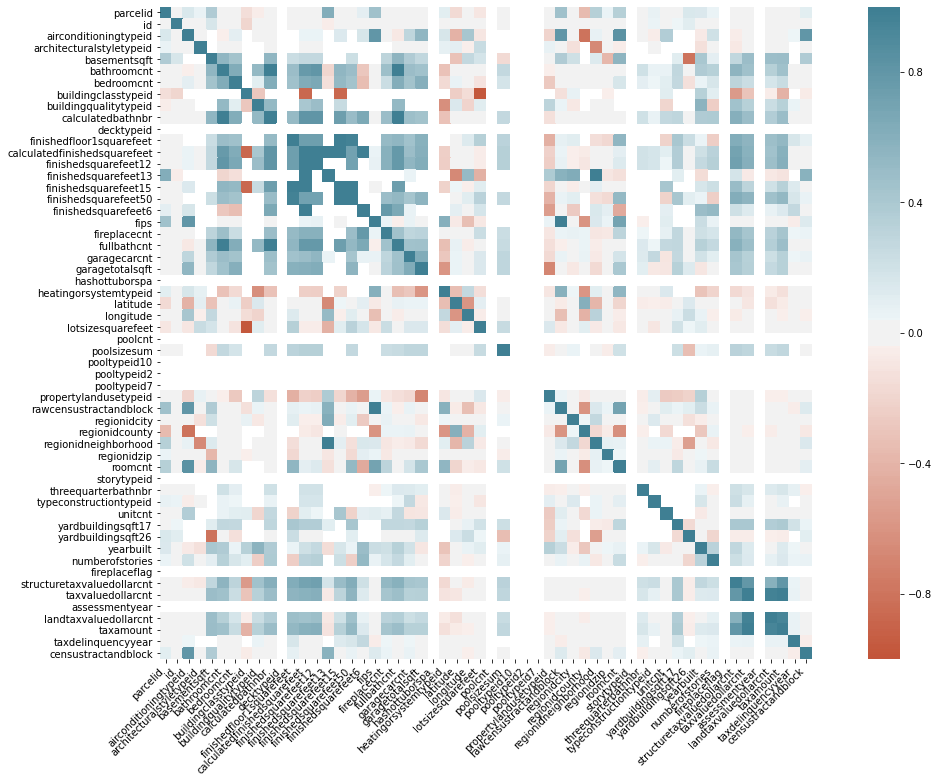

In [8]:
corr = df2.corr()

plt.figure(figsize=(20,12))

ax = sns.heatmap(
    corr,
    #annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Takeaway:** lots of columns in there actually show white stripes.  Tells me they don't have a whole lot of information on them and can be dropped in the overall scheme of things.

In [9]:
df3 = df.drop(columns=["decktypeid", "hashottuborspa", "poolcnt", "pooltypeid2",
                      "pooltypeid10", "pooltypeid7", "storytypeid", "fireplaceflag",
                      "assessmentyear"], axis=1)

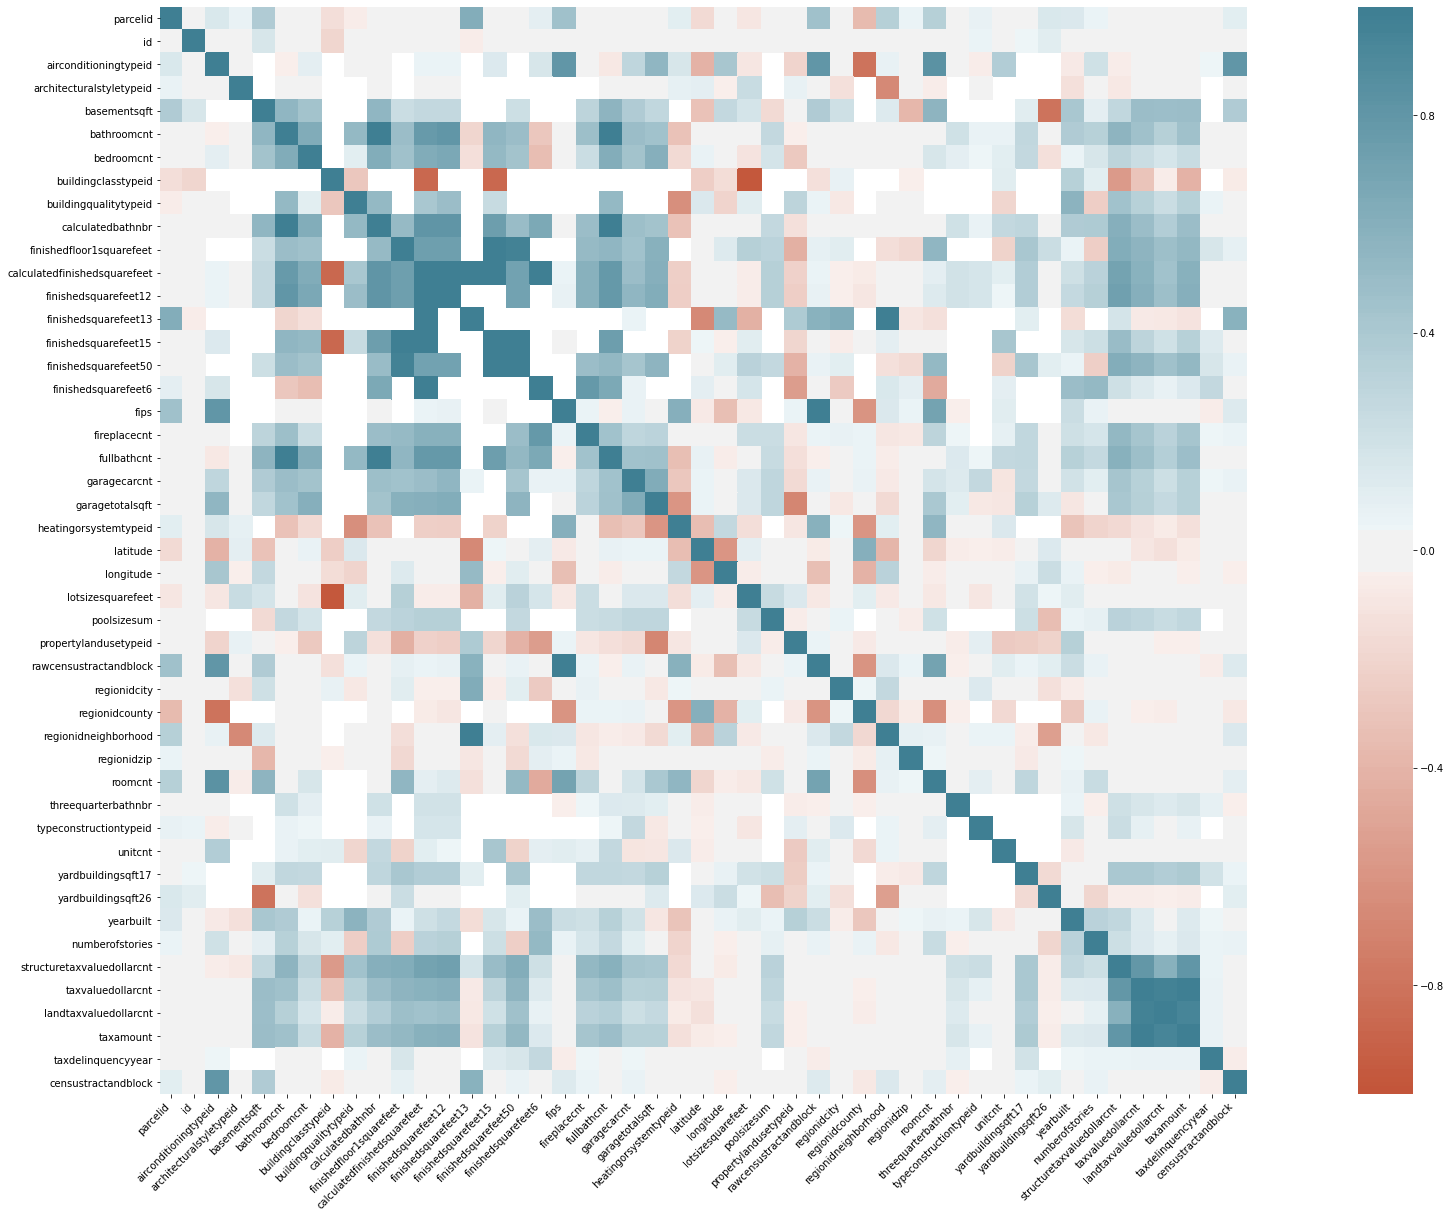

In [10]:
corr = df3.corr()

plt.figure(figsize=(40,20))

ax = sns.heatmap(
    corr,
    #annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Yeah, no.  Waste of time.  Was hoping to see some relationships, but no bueno - ugly.